# Table of Contents

* [Introduction](#Introduction)
* [Library Imports](#DE)
* [Dataset import](#DS)
    * [FEN from filename](#FEN)
    * [graph representation](#graph)
* [FEN to one-hot-encoded vectors](#func)
* [Image processing](#Image)
* [Training and evaluation]
* [Model]
* [Model accuracy]

# Introduction <a class="anchor" id="Introduction"></a>

This notebook was created for the computer vision final exam. The exam file in pdf has been attached in the exam folder. The main aim of the exercise is to find a proper location of chess coins from the given image.

For this exercise I took the dataset from kaggle the link is given below as per the exam instructions. The datset contains total 1 lakh images. The images splited 80K as train and 20K as test dataset. The dataset is in image format.

The methodology of solving this probelm as mention below step by step.

Several great works have been presented on this school case already and the aim of this notebook is not to create the best model out there. Instead, I wish to present a robust and easy methodology to solve computer vision classification problems.

# Library Imports

## All the import needed have been imported. 
* Glob: glob to read all the files at a one time 
* numpy: linear algebra
* matplotlib: For ploting the image
* keras Sequential: Sequential model is apporiate for a plain stack layer where each layer has exactly one input tensor and one output tensor
* keras dense, Dropout, Activation: These are the CNN pre-requirements that able for reduce the dimensions and give more accuracy using current activation function

In [1]:
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization


C:\Users\npram\anaconda3\envs\tenpy\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\npram\anaconda3\envs\tenpy\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\npram\anaconda3\envs\tenpy\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


# Dataset Imports

* Here, I am going to load the data using os library and using create an dataframe using pandas and this help us to understand about the data structure and data distribution clearly and further we can use this dataframe to extarct the labelling and analysing the position of each chess coins.

* To reduce the computation time in taking maximum 10K data from training set and 3K from test set

* Dataset link: https://www.kaggle.com/koryakinp/chess-positions

In [2]:
train_size = 10000
test_size = 3000

train = glob.glob("./dataset/train/*.jpeg")
test = glob.glob("./dataset/test/*.jpeg")

shuffle(train)
shuffle(test)

train = train[:train_size]
test = test[:test_size]

In [3]:
len(train), len(test)

(10000, 3000)

* As mentioned above i took the trainset = 1000 and testset = 3000 for reduce the computational time due to lack of time to train 80K train images and predict 20K images 

# FEN from filename

* Function to extract the FEN (Forsyth–Edwards Notation) from the filename
* Forsyth–Edwards Notation is a standard notation for describing a particular position board of the a chess game. The purpose of FEN is to provide all the necessary information to restart a game from a particular position.

* External Links: https://stackoverflow.com/questions/541390/extracting-extension-from-filename-in-python

In [4]:
def get_fen_from_filename(filename):
    base = os.path.basename(filename)
    return os.path.splitext(base)[0]

In [5]:
print(get_fen_from_filename(train[0]))
print(get_fen_from_filename(train[1]))

8-8-8-B7-1n2k3-B7-K7-8
4K1N1-8-8-8-8-5k2-8-Rn6


* Understanding: 1b2R3 means that on the first line you have 1 empty square, then a black bishop, 2 empty squares, then a white rook, 3 empty squares

# graph representation

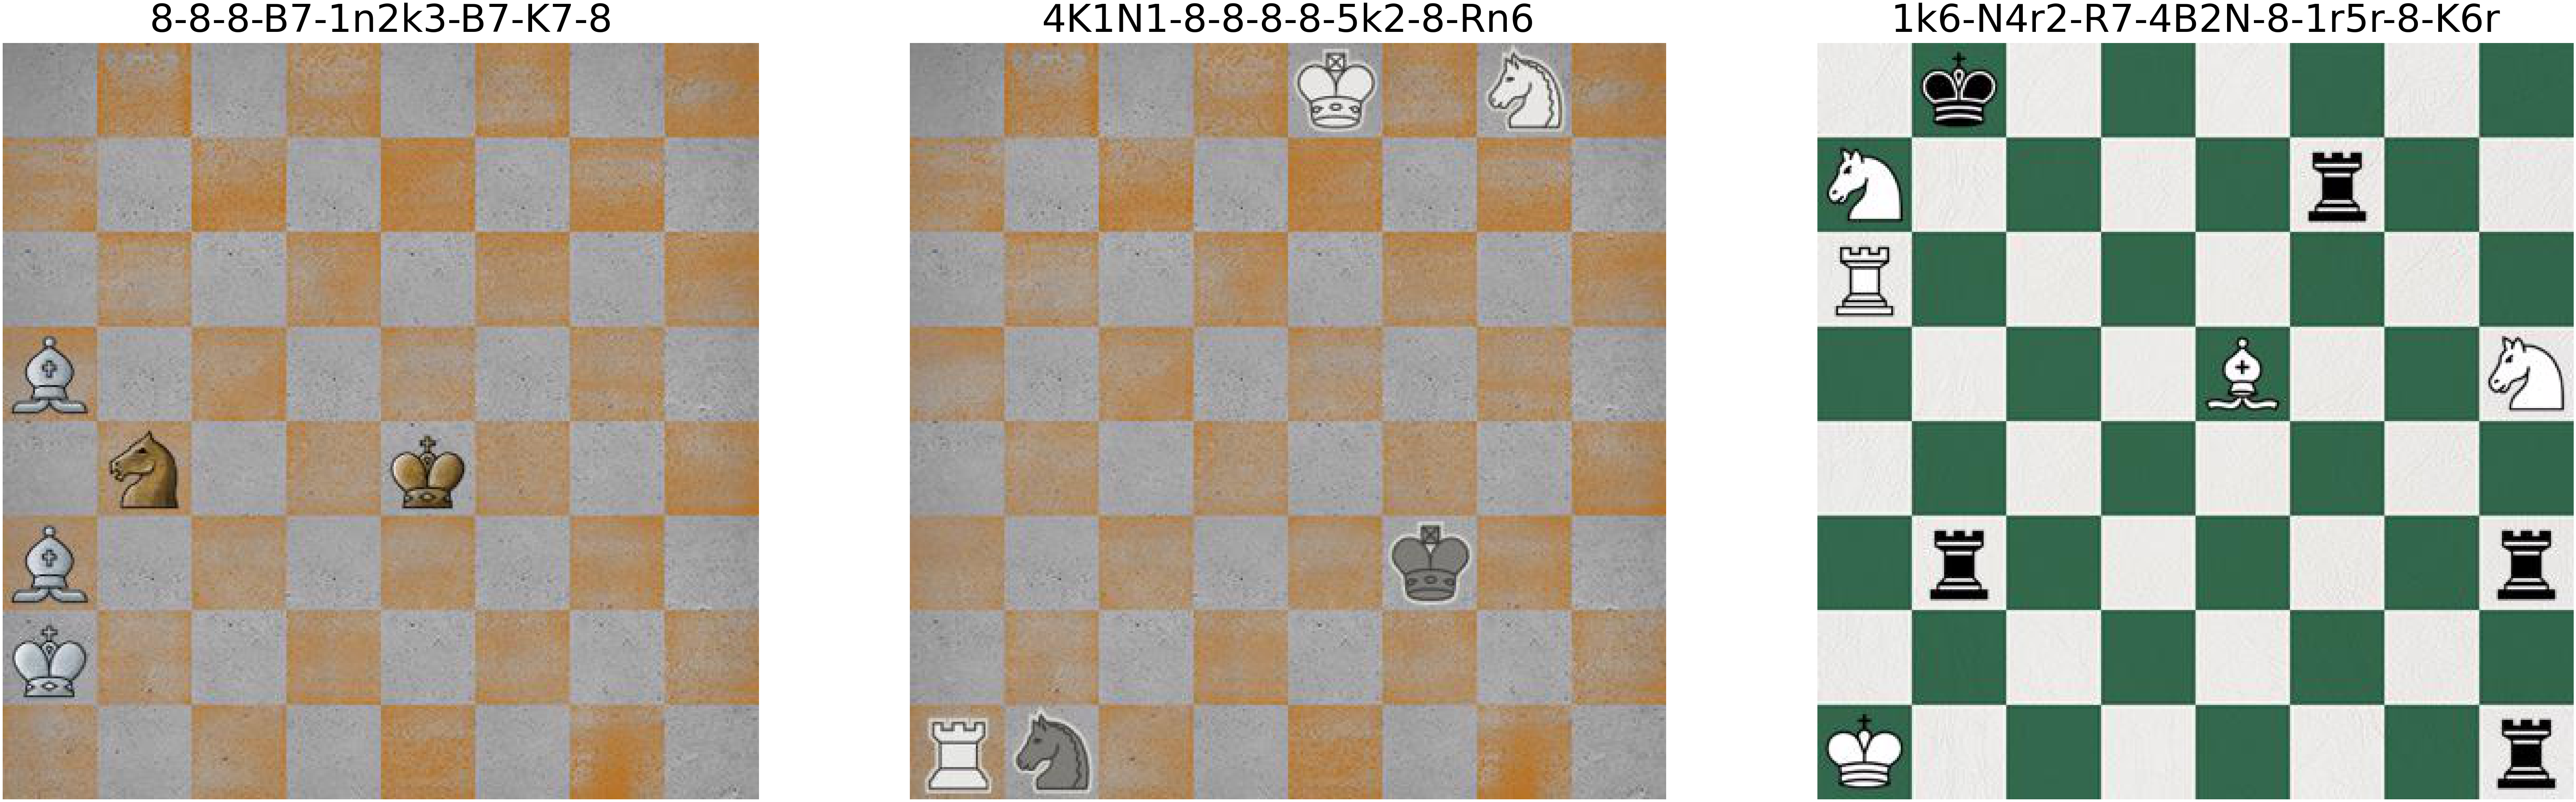

In [6]:
f, axarr = plt.subplots(1,3, figsize=(120, 120))

for i in range(0,3):
    axarr[i].set_title(get_fen_from_filename(train[i]), fontsize=100, pad=30)
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')

* These are the random images taken from the filepath and shown here

# Functions to convert FEN to one-hot-encoded vectors

* This function provides out of the box support for further step with exports to FEN. FEN is a description string listing the location of each coins on the board. For analysis, we want to transform this string into one-hot-encoding of the board. A one-hot-encoding is a 768 bit vector indicating wheather or not a coin position is present in the board

* | d |   |
* |   |   |
* | d |   |
* |   |   |
* |   | d |

* Assume that this is a chess board and d are the position of the coins 
in the as per the board position the postion represents in WP-a1, Wp-c1 and Bp-a1

* But using one-hot encoding we can change to the position representation after appling one-hot encoding the representation be like (0,0,1) postions for three coins

* External links :  https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [7]:
piece_symbols = 'prbnkqPRBNKQ'
def onehot_from_fen(filename):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = get_fen_from_filename(filename)
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

# Image processing 

* This function is used to downsmaple an image to 200 by 200 pixels and split an image of the chess board to 64 images of individual sqaures and drop redundant dimensions, reshape it

In [8]:
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img, channels=3)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

# Traning and evaluation function

* Features : Its an common sense that we have to train the Features variable 
* labels : not need while training but we are taking the whole image data to convert the image representaion to onehotencode we use labels
* batch_size : batch size used to reduce the computational time

* And the function is returning as an generator using "yield"

In [9]:
def train_gen(features, labels, batch_size):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_fen_from_filename(img))
        x = process_image(img)
        yield x, y

In [10]:
def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

# Model

* The model type that we will be using is Sequential. Sequential is the easiest way to built a model in keras. It allows you to build a model layer by layer. Each layer has weights that corresponds to the layer the follow it. 

* We use the add function to add layers to our model. We will add multiple layers go get more feature information but we should keep in minf about dimensonality. Which effects the model score. Finally we add an output layer.

* Dense is the layer type. Dense is a standard layer type that works for most cases. In the dense layer, all nodes in the previous layer connect to the nodes in the current layer. The number of nodes are randomly decides because none of the known the exact number of nodes that as be mentioned in each layer.

* Activation function for the layer. An Activation function alows model to take into account nonlinear relationships. The Activation function we are using if RELU for inputs and softmax for output

* The optimizer controls the learning rate. We will be using ‘adam’ as our optmizer. Adam is generally a good optimizer to use for many cases. The adam optimizer adjusts the learning rate throughout training

** Changes **

* Model changed to maxpooling2D. It downsmaples the input along its spatial dimensions
* Added BatchNormalization(). It helps in normalisation of dense layer input by mini-batch standard deviation.
* Add dropouts. These inactive some neural networks. This help in minimizing the dimensions with gaining more weighted features


External link: https://github.com/Pramod-Kumar808/computer_vision/blob/master/MINST.ipynb    (my github)

In [27]:

model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation=tf.nn.relu, input_shape=(25,25, 3)),
    Conv2D(32, kernel_size=(3,3), activation=tf.nn.relu),
    Flatten(),
    Dense(64, activation=tf.nn.relu),
    Dropout(0.2),
    Dense(32, activation=tf.nn.relu),
    Dropout(0.2),
    Dense(10, activation=tf.nn.softmax)])

* We have build the model. Here the mdoel summary which initiated.

In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 23, 23, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
flatten_3 (Flatten)          (None, 14112)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                903232    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)               

* As you increase the number of nodes and layers in a model, the model capacity increases. Increasing model capacity can lead to a more accurate model, up to a certain point, at which the model will stop improving.
* Here we compile the model with three parameters optimizer, loss function and metrics.

* As we selected activation for last layer is "Softmax". sofmax makes the output sun up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has a higher probability.

* Here used categorical crossentropy for our loss function. This is the most common choice for classification. A lower score indicated that the model is preforming better. And we used accuaracy metric to see the accuracy score on the validation set at the end of each epochs.

* Here the result says ture that the model is complied.

In [29]:

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])
print(model._is_compiled)

True


* Here the model is fitted to the train dataset and complied the result

In [31]:
model.fit_generator(train_gen(train, None, 64), steps_per_epoch=train_size)

res = (
  model.predict_generator(pred_gen(test, 64), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

pred_fens = np.array([one_hot for one_hot in res])
test_fens = np.array([get_fen_from_filename(fn) for fn in test])
final_accuracy = (pred_fens == test_fens).astype(float).mean()
print("Final Accuracy: {:1.5f}%".format(final_accuracy))

* The final is 0.910 %. This score is the model accuarcy score.